<a href="https://colab.research.google.com/github/natanaeldgsantos/py_machine_learning_projects/blob/main/An%C3%A1lise_de_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Churn

created by: Natanael Domingos


## 01.Entendimento do Negócio





> "Churn rate é a taxa que mede a rotatividade dos clientes de uma empresa. Apesar de ser o pesadelo de muitos empreendedores, a interpretação correta e a gestão dos resultados obtidos com o indicador podem ajudar a mudar o rumo dos negócios para melhor!"


referência: [Artigo blog Zendesk](https://www.zendesk.com.br/blog/churn-rate/)


In [1]:
# Libraries
import pandas as pd
import numpy as np
import os 

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## 02.Entrada de Dados

In [2]:
# Criando Diretório de trabalho

! rm -rf /content/dados
! mkdir /content/dados

WORK_DIR = os.getcwd()
DATA_DIR = os.path.join(WORK_DIR, 'dados')

In [3]:
# Leitura de Dados
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Treinamento Big Data/Python e PySpark/Python/Projeto 04: Churn/churn1.xlsx')

# Scorando a base de dados
score = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Treinamento Big Data/Python e PySpark/Python/Projeto 04: Churn/churn2.xlsx')

# Perfil Financeiro do Cliente
perfil = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Treinamento Big Data/Python e PySpark/Python/Projeto 04: Churn/churn3.xlsx')

# Target
target = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Treinamento Big Data/Python e PySpark/Python/Projeto 04: Churn/churn4.xlsx')

# Juntando as bases de dados
df = df.merge(score,  left_on= 'CustomerId', right_on = 'CustomerId',  how ='left')
df = df.merge(perfil, left_on= 'CustomerId', right_on = 'CustomerId',  how ='left')
df = df.merge(target, left_on= 'CustomerId', right_on = 'CustomerId',  how ='left')

df.head()

,CustomerId,Surname,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,15565701.0,Ferri,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0
1,15565706.0,Akobundu,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0
2,15565714.0,Cattaneo,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0
3,15565779.0,Kent,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0
4,15565796.0,Docherty,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0


## 03.Manipulação e Preparação dos Dados

### Verificando valores Duplicados

In [4]:
# Verificando valores duplicados considerando apenas a coluna id

# df[ df.duplicated( subset=['CustomerId'] ) ] # valores de id duplicados é em função de valores estarem nulos.

# Verificando valores Duplicados considerando todas variáveis

df[df.duplicated()]

,CustomerId,Surname,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited


In [5]:
# Filtrando colunas 

churn = df.drop(['CustomerId','Surname'], axis=1)
churn = churn.loc[churn['Exited'].notnull(),:]     # exclui registros onde o target é Missing
churn.columns


Index(['Geography', 'Gender', 'Age', 'EstimatedSalary', 'CreditScore',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Exited'],
      dtype='object')

In [6]:
# Sobre os Dados

churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Geography        9977 non-null   object 
 1   Gender           9983 non-null   object 
 2   Age              9991 non-null   float64
 3   EstimatedSalary  9976 non-null   object 
 4   CreditScore      9995 non-null   float64
 5   Tenure           9991 non-null   float64
 6   Balance          9981 non-null   float64
 7   NumOfProducts    9989 non-null   float64
 8   HasCrCard        9985 non-null   float64
 9   IsActiveMember   9985 non-null   float64
 10  Exited           9995 non-null   float64
dtypes: float64(8), object(3)
memory usage: 937.0+ KB


### Missing Values

In [7]:
# Tabela de Missings

metadata = pd.DataFrame()
metadata['Missings']    = churn.isnull().sum()
metadata['Missings %']  = round(churn.isnull().sum() / churn.shape[0], 3)
metadata

,Missings,Missings %
Geography,18,0.002
Gender,12,0.001
Age,4,0.000
EstimatedSalary,19,0.002
CreditScore,0,0.000
Tenure,4,0.000
Balance,14,0.001
NumOfProducts,6,0.001
HasCrCard,10,0.001
IsActiveMember,10,0.001


### Tipos de Dados

In [8]:
churn.dtypes

Geography           object
Gender              object
Age                float64
EstimatedSalary     object
CreditScore        float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
Exited             float64
dtype: object

In [9]:
# EstimatedSalary to Float

# Erro valores 'abc' entre dados númericos

churn['EstimatedSalary'].unique()

array([90212.38, 83256.26, 96517.97, ..., 199808.1, 60728.89, 77789.01],
      dtype=object)

In [10]:
# Quais registros contêm dados não númericos?

churn[ churn['EstimatedSalary'].str.isalpha() == True ]

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
4973,France,Female,31.0,abc,666.0,2.0,79589.43,1.0,0.0,0.0,0.0
6285,Germany,Female,21.0,abc,685.0,6.0,97956.50,1.0,1.0,1.0,0.0
8136,France,Male,27.0,abc,627.0,1.0,62092.90,1.0,1.0,1.0,0.0
8824,Germany,Male,31.0,abc,670.0,1.0,142631.54,2.0,1.0,1.0,0.0
8834,France,Male,39.0,abc,740.0,9.0,0.00,2.0,1.0,0.0,0.0


In [11]:
# Corrigindo para NaN

churn['EstimatedSalary'] = pd.to_numeric(churn['EstimatedSalary'], errors='coerce')
churn.dtypes


Geography           object
Gender              object
Age                float64
EstimatedSalary    float64
CreditScore        float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
Exited             float64
dtype: object

In [12]:
# Corrigindo a Coluna Gender

churn['Gender'].unique()

array(['Female', 'Male', nan, 'M', 'F'], dtype=object)

In [13]:
churn['Gender'].value_counts()

Male      5424
Female    4517
M           25
F           17
Name: Gender, dtype: int64

In [14]:
# Padronizando as categorias

gender_pattern = {
    
            'F':'Female',
            'M':'Male',
            'Male':'Male',
            'Female':'Female'
}

churn['Gender'] = churn['Gender'].map(gender_pattern)

In [15]:
churn['Gender'].value_counts()

Male      5449
Female    4534
Name: Gender, dtype: int64

In [16]:
# Corrigindo as Regiões
churn['Geography'] = churn['Geography'].fillna('Indeterminada') # alterando Nulos para "Indeterminado"

In [17]:
# Verificando Salários com valores Negativos
churn[churn['EstimatedSalary'] < 0]


,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
5627,Spain,Male,27.0,-94544.88,712.0,10.0,0.00,1.0,1.0,0.0,0.0
5630,Germany,Male,38.0,-46562.02,552.0,10.0,132271.12,2.0,1.0,1.0,0.0
6903,France,Female,27.0,-104112.00,775.0,4.0,152309.37,1.0,1.0,0.0,0.0
7058,France,Female,35.0,-31050.02,602.0,5.0,0.00,2.0,1.0,0.0,0.0
8135,Spain,Male,26.0,-95159.13,597.0,5.0,0.00,2.0,0.0,1.0,0.0


In [18]:
# Corrigindo salários negativos
churn.loc[ churn['EstimatedSalary'] < 0 ,'EstimatedSalary' ] =  np.nan 

In [19]:
# Preenchendo Valores Missing 

# Regras

# Gender Missing - Moda
churn['Gender'] = churn['Gender'].fillna(churn['Gender'].mode()[0])

# Age Missing - Média
churn['Age'] = churn['Age'].fillna(churn['Age'].mean())

# EstimatedSalary - Média
churn['EstimatedSalary'] = churn['EstimatedSalary'].fillna(churn['EstimatedSalary'].mean())

# CreditScore - Média
churn['CreditScore'] = churn['CreditScore'].fillna(churn['CreditScore'].mean())

churn.isnull().sum()

Geography           0
Gender              0
Age                 0
EstimatedSalary     0
CreditScore         0
Tenure              4
Balance            14
NumOfProducts       6
HasCrCard          10
IsActiveMember     10
Exited              0
dtype: int64

## 04.EDA - Análise Exploratória dos Dados

- Agrupamentos
- Outliers
- Distribuições
- Visualizações

### Hipóteses

O conjunto de variáveis disponível leva a crer que estamos realizando a predição de Churn para clientes de uma instituição financeira. 

Algumas hipóteses que podemos levantar, utilizando o conhecimento de negócio, são. 

- Será que clientes com maior número de produtos (relacionamento) tem menor probabilidade de cancelar?

Qual o perfil financeiro do cliente que cancela?
  - Saldo em conta baixo (Balance)?
  - Salário menor?
  - Menor Score?
  - São os que não possuem cartão de crédito ou qualquer outro serviço?
  

  
  



In [20]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,9995.0,38.920929,10.483439,18.00,32.000,37.000000,44.000,92.00
EstimatedSalary,9995.0,100098.239113,57420.653716,11.58,51227.745,100098.239113,149170.585,199992.48
CreditScore,9995.0,650.507454,96.650673,350.00,584.000,652.000000,717.500,850.00
Tenure,9991.0,5.012511,2.892284,0.00,3.000,5.000000,7.000,10.00
Balance,9981.0,76469.195306,62391.028951,0.00,0.000,97188.620000,127637.920,250898.09
NumOfProducts,9989.0,1.633397,5.540631,-5.00,1.000,1.000000,2.000,456.00
HasCrCard,9985.0,0.705458,0.455859,0.00,0.000,1.000000,1.000,1.00
IsActiveMember,9985.0,0.515073,0.499798,0.00,0.000,1.000000,1.000,1.00
Exited,9995.0,0.203702,0.402770,0.00,0.000,0.000000,0.000,1.00


In [21]:
churn.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0


### Engajamento - IsActiveMember

In [22]:
import plotly.graph_objects as go

group_target = churn.groupby('IsActiveMember').size().to_frame(name ='Count').reset_index()
group_target["Label"] = group_target['IsActiveMember'].map({0.0:"Active",1.0:"Inactive"})

fig = go.Figure( data= [go.Pie( labels=group_target['Label'], values = group_target['Count'], title="Distribuição do Target")])
fig.show()

### Explorando Regiões

In [23]:
# Quais regiões são atendidas

n_regioes = churn['Geography'].nunique()

print(f'São atendidas {n_regioes} regiões\n')
print('Sendo elas:')
for region in churn['Geography'].unique():
  print('* ',region)

São atendidas 4 regiões

Sendo elas:
*  Spain
*  France
*  Germany
*  Indeterminada


In [24]:
# Agrupando por País

groupby_country = churn.groupby('Geography').size()
groupby_country = groupby_country.reset_index(name='Count')

groupby_country.sort_values(by='Count',ascending=False)

,Geography,Count
0,France,5004
1,Germany,2503
3,Spain,2470
2,Indeterminada,18


In [25]:
# Visualização da distribuição por País

fig = px.scatter(
                  
                  groupby_country.sort_values(by='Count',ascending=False), # Do maior pro menor
                  title= "Qtd Clientes por País",
                  x="Geography", 
                  y="Count",
	                size="Count", 
                  color="Geography",
                  hover_name="Geography",                   
                  size_max=75
                )
fig.show()

In [26]:
cubo_analitico = churn.groupby(['Geography','Gender']).size()
cubo_analitico.head()


Geography      Gender
France         Female    2255
               Male      2749
Germany        Female    1189
               Male      1314
Indeterminada  Female       5
dtype: int64

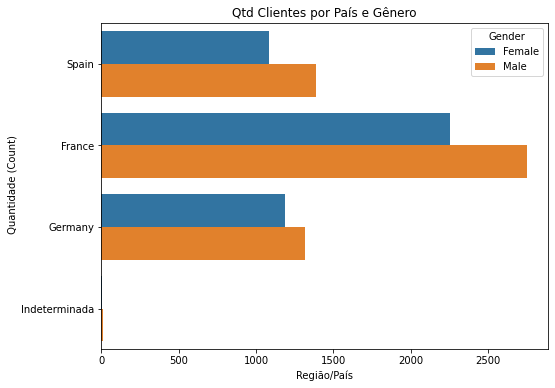

In [27]:
# Quantidade de Clientes por Pais e por Gênero
plt.figure(figsize=(8,6))
sns.countplot(data= churn, y='Geography', hue='Gender')
plt.title('Qtd Clientes por País e Gênero')
plt.ylabel(' Quantidade (Count)')
plt.xlabel('Região/País')
plt.show()

In [28]:
churn.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0


### Explorando Faixas de Idade

In [29]:
fig = px.histogram(churn, x='Age',title='Histograma de Idades')
fig.show()

In [30]:
# Grupos de Idade

age_groups = [20,29,39,49,59,69,79]
churn['AgeBins'] = pd.cut(x = churn['Age'], bins = age_groups ).astype('string')

churn.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,AgeBins
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,"(29.0, 39.0]"
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,"(29.0, 39.0]"
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,"(39.0, 49.0]"
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,"(29.0, 39.0]"
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,"(39.0, 49.0]"


In [31]:
churn.dtypes

Geography           object
Gender              object
Age                float64
EstimatedSalary    float64
CreditScore        float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
Exited             float64
AgeBins             string
dtype: object

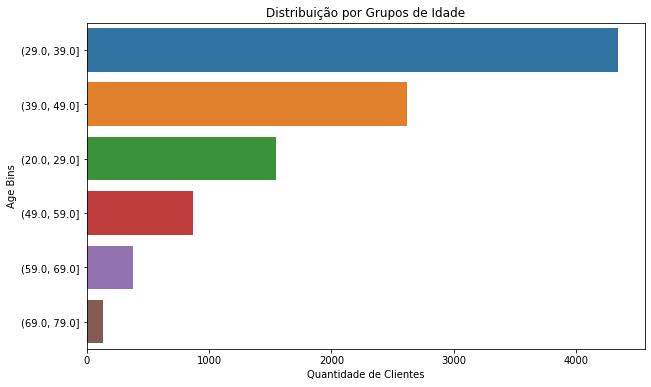

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(data=churn, y='AgeBins')
plt.title('Distribuição por Grupos de Idade')
plt.ylabel('Age Bins')
plt.xlabel('Quantidade de Clientes')
plt.show()

In [33]:
# Agrupamento por Idade
# Média de idade por cada País/Gênero
churn.groupby(['Geography','Gender'])['Age'].mean().round()

Geography      Gender
France         Female    39.0
               Male      38.0
Germany        Female    40.0
               Male      39.0
Indeterminada  Female    37.0
               Male      38.0
Spain          Female    39.0
               Male      39.0
Name: Age, dtype: float64

### Faixas de Score 

In [34]:
churn.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,AgeBins
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,"(29.0, 39.0]"
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,"(29.0, 39.0]"
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,"(39.0, 49.0]"
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,"(29.0, 39.0]"
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,"(39.0, 49.0]"


In [35]:
# Média de Score por Faixa de Idade

churn.groupby(['AgeBins'])['CreditScore'].mean().round().sort_values(ascending=False)

AgeBins
(69.0, 79.0]    665.0
(29.0, 39.0]    652.0
(20.0, 29.0]    650.0
(39.0, 49.0]    649.0
(59.0, 69.0]    648.0
(49.0, 59.0]    646.0
Name: CreditScore, dtype: float64

In [36]:
# Cubo Analytico (Scoragem)

cubo_score = churn.groupby(['Geography','Gender','AgeBins'])['CreditScore'].mean().round().to_frame(name="Mean Score").reset_index()
cubo_score.sort_values(by=['Geography', 'Mean Score'], ascending=False)

,Geography,Gender,AgeBins,Mean Score
37,Spain,Female,"(69.0, 79.0]",686.0
43,Spain,Male,"(69.0, 79.0]",665.0
35,Spain,Female,"(49.0, 59.0]",658.0
33,Spain,Female,"(29.0, 39.0]",655.0
40,Spain,Male,"(39.0, 49.0]",654.0
39,Spain,Male,"(29.0, 39.0]",651.0
41,Spain,Male,"(49.0, 59.0]",650.0
36,Spain,Female,"(59.0, 69.0]",648.0
38,Spain,Male,"(20.0, 29.0]",648.0
34,Spain,Female,"(39.0, 49.0]",647.0


In [37]:
# Quantiles por Score

fig = px.box(churn, y='CreditScore',x='Geography', title='Quantil do Score por País')

fig.show()

In [38]:
# Grupos Homogêneos por Faixa de Score

score_labels = range(0,9)
score_bins   = [0,99,199,299,399,499,599,699,799,899]

print(' Min: ',churn['CreditScore'].min() )
print(' Max: ',churn['CreditScore'].max() )

churn['GH'] = pd.cut(churn['CreditScore'],bins=score_bins, labels=score_labels)

 Min:  350.0
 Max:  850.0


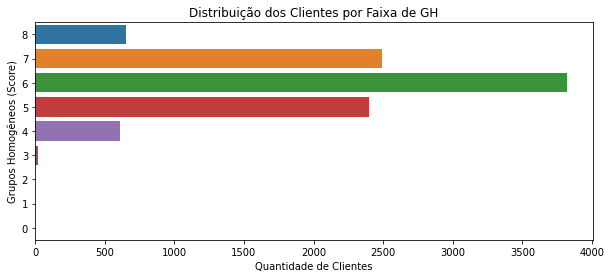

In [39]:
# Quantidade de Clientes por Grupo Homogêneo

labels_order = reversed(range(0,9))

plt.figure(figsize=(10,4))
sns.countplot(data=churn, y= 'GH',order=labels_order)
plt.title('Distribuição dos Clientes por Faixa de GH')
plt.ylabel('Grupos Homogêneos (Score)')
plt.xlabel('Quantidade de Clientes')
plt.show()

### Tenure - Tempo de Contrato

In [40]:
# tempo de contrato em meses

churn['Tenure'].value_counts().sort_index()

0.0      413
1.0     1035
2.0     1045
3.0     1009
4.0      988
5.0     1012
6.0      966
7.0     1026
8.0     1025
9.0      982
10.0     490
Name: Tenure, dtype: int64

In [41]:
# Cubo por quantidade de meses de contrato

cubo_tenure = churn.groupby(['Geography','Gender','AgeBins','GH','IsActiveMember'])['Tenure'].mean().to_frame(name='Mean of Tenure').reset_index().dropna().sort_values(by='Mean of Tenure')
cubo_tenure['IsActiveMember'] = cubo_tenure['IsActiveMember'].map({1.0: 'Yes',0.0:'No'})

cubo_tenure.loc[ (cubo_tenure['Geography'] == 'France') & (cubo_tenure['IsActiveMember'] == 'Yes'), : ] # Cubo por clientes Ativos


,Geography,Gender,AgeBins,GH,IsActiveMember,Mean of Tenure
43,France,Female,"(39.0, 49.0]",3,Yes,0.000000
207,France,Male,"(69.0, 79.0]",4,Yes,2.000000
81,France,Female,"(59.0, 69.0]",4,Yes,3.333333
71,France,Female,"(49.0, 59.0]",8,Yes,3.400000
211,France,Male,"(69.0, 79.0]",6,Yes,3.642857
...,...,...,...,...,...,...
17,France,Female,"(20.0, 29.0]",8,Yes,6.000000
63,France,Female,"(49.0, 59.0]",4,Yes,6.800000
45,France,Female,"(39.0, 49.0]",4,Yes,6.875000
215,France,Male,"(69.0, 79.0]",8,Yes,7.000000


In [42]:
cubo_tenure.loc[ (cubo_tenure['Geography'] == 'France') & (cubo_tenure['IsActiveMember'] == 'Yes'), : ] # Cubo por clientes Ativos

,Geography,Gender,AgeBins,GH,IsActiveMember,Mean of Tenure
43,France,Female,"(39.0, 49.0]",3,Yes,0.000000
207,France,Male,"(69.0, 79.0]",4,Yes,2.000000
81,France,Female,"(59.0, 69.0]",4,Yes,3.333333
71,France,Female,"(49.0, 59.0]",8,Yes,3.400000
211,France,Male,"(69.0, 79.0]",6,Yes,3.642857
...,...,...,...,...,...,...
17,France,Female,"(20.0, 29.0]",8,Yes,6.000000
63,France,Female,"(49.0, 59.0]",4,Yes,6.800000
45,France,Female,"(39.0, 49.0]",4,Yes,6.875000
215,France,Male,"(69.0, 79.0]",8,Yes,7.000000


In [43]:
churn.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,AgeBins,GH
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,"(29.0, 39.0]",6
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,"(29.0, 39.0]",6
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,"(39.0, 49.0]",6
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,"(29.0, 39.0]",6
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,"(39.0, 49.0]",7


In [44]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = ['EstimatedSalary','CreditScore','Balance','NumOfProducts']

cubo = churn[columns]
cubo_normalizado = pd.DataFrame( scaler.fit_transform(cubo), columns = columns)
cubo_normalizado['IsActiveMember'] = churn['IsActiveMember']

fig = px.scatter_3d(
                  cubo_normalizado, 
                  x= 'EstimatedSalary', 
                  y= 'CreditScore',
                  z= 'Balance',
                  color='IsActiveMember',
                  width=1200, 
                  height=650,
                  title="3D Scatter Plot")
fig.show()

## 4.1Target - Exited




### Churn Rate

In [45]:
group_target = churn.groupby('Exited').size().to_frame(name ='Count').reset_index()
group_target["Label"] = group_target['Exited'].map({0.0:"Not Churn",1.0:"Churn"})

fig = go.Figure( data= [go.Pie( labels=group_target['Label'], values = group_target['Count'], title="Distribuição do Target")])
fig.show()

### Churn Receita

In [46]:
fig = px.pie(df, values='Balance', names='Exited', title='Balance by Target')
fig.show()

## 05.Modelagem

In [47]:
df = churn.copy()
df.head()

,Geography,Gender,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,AgeBins,GH
0,Spain,Female,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,"(29.0, 39.0]",6
1,Spain,Male,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,"(29.0, 39.0]",6
2,France,Male,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,"(39.0, 49.0]",6
3,Germany,Female,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,"(29.0, 39.0]",6
4,Germany,Male,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,"(39.0, 49.0]",7


### One Hot Encoding

In [48]:
# One Hot Encoding 

df = pd.get_dummies( data=df, columns = ['Geography'])
df = pd.get_dummies( data=df, columns = ['Gender'], drop_first=True).drop('AgeBins',axis=1)
df['GH'] = df['GH'].astype(int) # label encoding, category to number
df.head()

,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,GH,Geography_France,Geography_Germany,Geography_Indeterminada,Geography_Spain,Gender_Male
0,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,6,0,0,0,1,0
1,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,6,0,0,0,1,1
2,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,6,1,0,0,0,1
3,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,6,0,1,0,0,0
4,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,7,0,1,0,0,1


In [49]:
df.dtypes

Age                        float64
EstimatedSalary            float64
CreditScore                float64
Tenure                     float64
Balance                    float64
NumOfProducts              float64
HasCrCard                  float64
IsActiveMember             float64
Exited                     float64
GH                           int64
Geography_France             uint8
Geography_Germany            uint8
Geography_Indeterminada      uint8
Geography_Spain              uint8
Gender_Male                  uint8
dtype: object

In [50]:
df.isnull().sum()

Age                         0
EstimatedSalary             0
CreditScore                 0
Tenure                      4
Balance                    14
NumOfProducts               6
HasCrCard                  10
IsActiveMember             10
Exited                      0
GH                          0
Geography_France            0
Geography_Germany           0
Geography_Indeterminada     0
Geography_Spain             0
Gender_Male                 0
dtype: int64

In [51]:
# Replace Missing Values by Mean

df['Tenure']         = df['Tenure'].fillna( df['Tenure'].mean() )
df['Balance']        = df['Balance'].fillna( df['Balance'].mean() )
df['HasCrCard']      = df['HasCrCard'].fillna( df['HasCrCard'].mean() )
df['NumOfProducts']  = df['NumOfProducts'].fillna( df['NumOfProducts'].mean() )
df['IsActiveMember'] = df['IsActiveMember'].fillna( df['IsActiveMember'].mean() )

df.isnull().sum()

Age                        0
EstimatedSalary            0
CreditScore                0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
Exited                     0
GH                         0
Geography_France           0
Geography_Germany          0
Geography_Indeterminada    0
Geography_Spain            0
Gender_Male                0
dtype: int64

### Normalização

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_normalizado = scaler.fit_transform(df)

df_normalizado

array([[ 0.00754286, -0.17217418,  0.49140809, ..., -0.04247528,
         1.7454394 , -1.09747675],
       [-0.37403041, -0.29332341, -0.39843882, ..., -0.04247528,
         1.7454394 ,  0.91118103],
       [ 0.7706894 , -0.06235471, -0.51225645, ..., -0.04247528,
        -0.57292164,  0.91118103],
       ...,
       [ 0.00754286,  1.73656764, -1.13307987, ..., -0.04247528,
        -0.57292164, -1.09747675],
       [-0.46942373, -0.68566476,  1.11223151, ..., -0.04247528,
        -0.57292164, -1.09747675],
       [ 0.10293618, -0.38854217, -0.37774471, ..., -0.04247528,
         1.7454394 , -1.09747675]])

### Clusterização com DB Scan

In [53]:
from sklearn.cluster import DBSCAN

# Criação do Modelo
DBSCAN_cluster = DBSCAN(eps=10, min_samples=5)

# Treinamento
DBSCAN_cluster.fit(df_normalizado)

df['DBSCAN_Labels'] = DBSCAN_cluster.labels_

df.head()

,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,GH,Geography_France,Geography_Germany,Geography_Indeterminada,Geography_Spain,Gender_Male,DBSCAN_Labels
0,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,6,0,0,0,1,0,0
1,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,6,0,0,0,1,1,0
2,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,6,1,0,0,0,1,0
3,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,6,0,1,0,0,0,0
4,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,7,0,1,0,0,1,0


In [54]:
df['DBSCAN_Labels'].value_counts()

 0    9974
 1      18
-1       3
Name: DBSCAN_Labels, dtype: int64

### Clusterização com o KMEANs

In [55]:
from pandas.core.common import random_state
from sklearn.cluster import KMeans

# Construindo o modelo
kmeans = KMeans( 
                    n_clusters=2, 
                    random_state=42
                )

# Treinando o Modelo
kmeans.fit(df_normalizado)

df['KMeans_Labels'] = kmeans.labels_
df.head()

,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,GH,Geography_France,Geography_Germany,Geography_Indeterminada,Geography_Spain,Gender_Male,DBSCAN_Labels,KMeans_Labels
0,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,6,0,0,0,1,0,0,1
1,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,6,0,0,0,1,1,0,1
2,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,6,1,0,0,0,1,0,0
3,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,6,0,1,0,0,0,0,1
4,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,7,0,1,0,0,1,0,1


In [56]:
df['KMeans_Labels'].value_counts()

0    5004
1    4991
Name: KMeans_Labels, dtype: int64

In [57]:
results = df[['Exited','DBSCAN_Labels','KMeans_Labels']]
results.head()

,Exited,DBSCAN_Labels,KMeans_Labels
0,0.0,0,1
1,1.0,0,1
2,0.0,0,0
3,0.0,0,1
4,0.0,0,1


In [58]:
# Validando Acertos e Errors
results['DBSCAN_Acertou?'] = np.where( results['DBSCAN_Labels'] == results['Exited'], 1,0)
results['KMeans_Acertou?'] = np.where( results['KMeans_Labels'] == results['Exited'], 1,0)


results.head()

,Exited,DBSCAN_Labels,KMeans_Labels,DBSCAN_Acertou?,KMeans_Acertou?
0,0.0,0,1,1,0
1,1.0,0,1,0,1
2,0.0,0,0,1,1
3,0.0,0,1,1,0
4,0.0,0,1,1,0


In [59]:
print()
print('O KMeans acertou {} de {}, ou seja {:.2f}%'.format( results['KMeans_Acertou?'].sum(), results.shape[0], results['KMeans_Acertou?'].sum() / results.shape[0] ))
print()
print('O DBScan acertou {} de {}, ou seja {:.2f}%'.format( results['DBSCAN_Acertou?'].sum(), results.shape[0], results['DBSCAN_Acertou?'].sum() / results.shape[0] ))


O KMeans acertou 5420 de 9995, ou seja 0.54%

O DBScan acertou 7946 de 9995, ou seja 0.79%


In [60]:
df.head()

,Age,EstimatedSalary,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,GH,Geography_France,Geography_Germany,Geography_Indeterminada,Geography_Spain,Gender_Male,DBSCAN_Labels,KMeans_Labels
0,39.0,90212.38,698.0,9.0,161993.89,1.0,0.0,0.0,0.0,6,0,0,0,1,0,0,1
1,35.0,83256.26,612.0,1.0,0.00,1.0,1.0,1.0,1.0,6,0,0,0,1,1,0,1
2,47.0,96517.97,601.0,1.0,64430.06,2.0,0.0,1.0,0.0,6,1,0,0,0,1,0,0
3,30.0,188258.49,627.0,6.0,57809.32,1.0,1.0,0.0,0.0,6,0,1,0,0,0,0,1
4,48.0,74510.65,745.0,10.0,96048.55,1.0,1.0,0.0,0.0,7,0,1,0,0,1,0,1


## Predição de Churn - Competição de Modelos

### Conjuntos de treinamento e Teste

In [61]:
from sklearn.model_selection import train_test_split


new_df = df.drop(['KMeans_Labels','DBSCAN_Labels'],axis=1).copy()

X = new_df.drop('Exited', axis = 1) 
y = new_df['Exited']

# 80% para treinamento dos modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

print('**** Dados de Treinamento ****')
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('**** Dados de Teste ****')
print('X_test',  X_test.shape)
print('y_test',  y_test.shape)

**** Dados de Treinamento ****
X_train (7996, 14)
y_train (7996,)

**** Dados de Teste ****
X_test (1999, 14)
y_test (1999,)


In [62]:
# Conjunto de Resultados

df_outputs = pd.DataFrame()

df_outputs['Real/Observado'] = y_test

df_outputs.head()

,Real/Observado
3145,0.0
1457,1.0
4530,1.0
39,0.0
4529,0.0


### Modelo 01 - Regressão Logística

In [63]:
from sklearn.linear_model import LogisticRegression

# Criação do modelo
rl = LogisticRegression(random_state=42)

# Treinamento do Modelo
rl.fit(X_train,y_train)

# Salvando predições do modelo 
df_outputs['Pred_LogRegression'] = rl.predict(X_test)

### Modelo 02 - Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

# Criação e parametrização do modelo
rfc = RandomForestClassifier(   
                                random_state = 42, 
                                n_estimators = 100
                            )

# Treinamento do Modelo
rfc.fit(X_train,y_train)

# Salvando as predições
df_outputs['Pred_RandForest'] = rfc.predict(X_test)

Text(0.5, 1.0, 'Top Features do Random Forest')

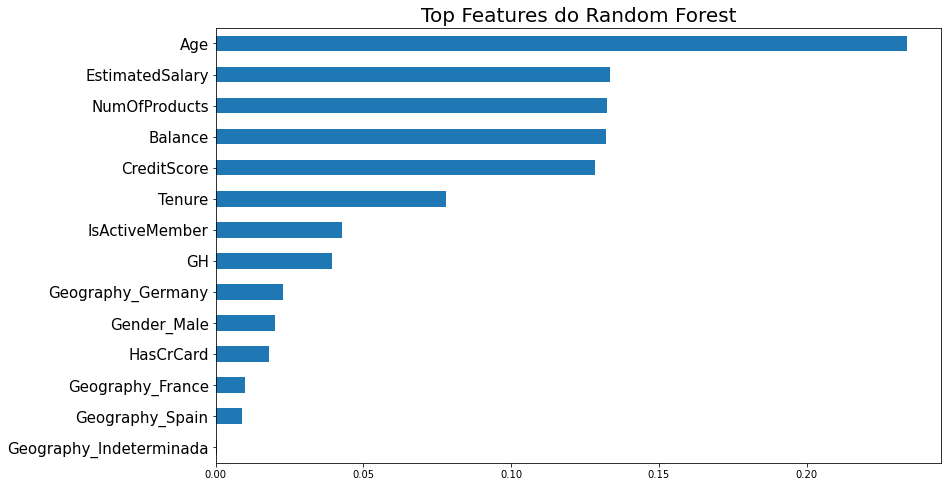

In [65]:
# Features mais Importantes

(pd.Series( rfc.feature_importances_, index=X.columns ).nlargest(47).plot(kind='barh', figsize=[13,8]).invert_yaxis())

plt.yticks(size=15)
plt.title('Top Features do Random Forest', size=20)

### Modelo 03 - XGBoost

In [66]:
from xgboost import XGBClassifier

# Criação e parametrização do modelo
boost = XGBClassifier(   
                        use_label_encoder=False                        
                        
                      )

# Treinamento do Modelo
boost.fit(X_train,y_train)

# Salvando as predições
df_outputs['Pred_XGBoost'] = boost.predict(X_test)

Text(0.5, 1.0, 'Top Features do XGBoost')

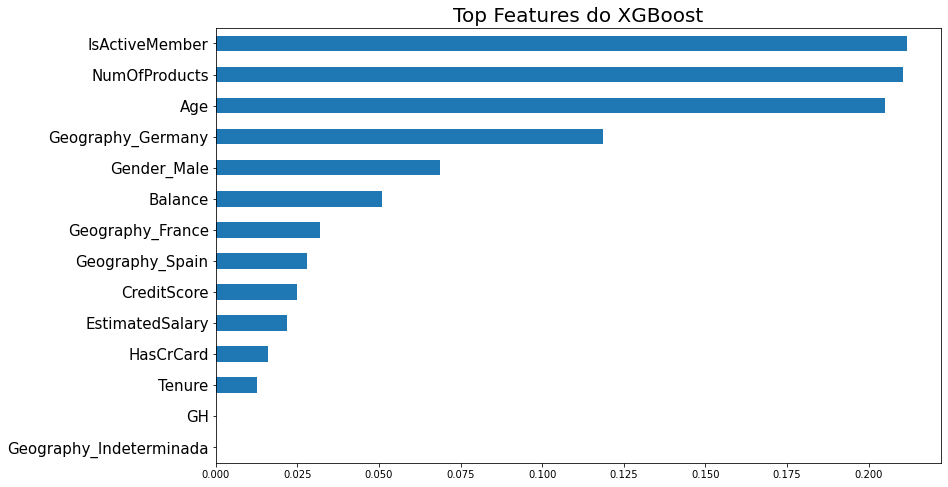

In [67]:
# Features mais Importantes

(pd.Series( boost.feature_importances_, index=X.columns ).nlargest(47).plot(kind='barh', figsize=[13,8]).invert_yaxis())

plt.yticks(size=15)
plt.title('Top Features do XGBoost', size=20)

## 06.Avaliação dos Modelos

In [68]:
df_outputs.head()

,Real/Observado,Pred_LogRegression,Pred_RandForest,Pred_XGBoost
3145,0.0,0.0,0.0,0.0
1457,1.0,0.0,0.0,0.0
4530,1.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0
4529,0.0,1.0,1.0,1.0


In [69]:
# Importando as Métricas de Avaliação

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

In [70]:

# Cálcula as Métricas de Avaliação para predições realizadas por Modelo
def calc_metrics():

  """

    in - não recebe nenhum parâmetro de entrada, mas utiliza o dataframe de predições df_outputs
    out - retorn um array de dicionários com as métricas das predições realizadas

  """

  model = ['Regressão Logística','Random Forest','XGBoosting'] # titulos para os modelos
  results = []

  for index, column in enumerate(df_outputs.drop('Real/Observado',axis=1).columns): # itera por cada coluna com predições

    y_test = df_outputs['Real/Observado']
    y_pred = df_outputs[column]

    # Métricas de Avaliação
    accuracy  = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='weighted')
    recall    = recall_score(y_test,y_pred,average='weighted')
    f1        = f1_score(y_test,y_pred,average='weighted')

    # Métricas por Modelo
    out = {

          "Modelo":model[index],
          "Acurácia":accuracy,
          "Precisão":precision,
          "Recal":recall,
          "F1 Score":f1 

    }

    results.append(out)
  
  return results


In [71]:
dict_metricas = calc_metrics()

df_metricas = pd.DataFrame(dict_metricas)

df_metricas.sort_values(by='Acurácia', ascending=False)
  

,Modelo,Acurácia,Precisão,Recal,F1 Score
2,XGBoosting,0.859930,0.848309,0.859930,0.844742
1,Random Forest,0.858929,0.847105,0.858929,0.843120
0,Regressão Logística,0.799900,0.721847,0.799900,0.733443
